In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

Using TensorFlow backend.


In [2]:
def accuracy_plot(model, title): 
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def loss_plot(model, title): 
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# plotting

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def confusion_plot(y_true_labels, y_pred_labels, title, class_names): 

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("All data confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=title)

    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=title)

    plt.show()

In [3]:
# read in off-target data from elevation team
# this is th.e CD33 data (see Doench 2016 paper) 
data_dir = '/data/'
# diff sheets, so need to read in 
file_name = data_dir + 'CD33_data_postfilter.csv'
df = pd.read_csv(file_name, sep = ',')

In [4]:
df.head(5)

,ConstructBarcode,MutatedSequence,WTSequence,Annotation,TranscriptID,Protein Annotation,Day21-ETP,Category,Position
0,TGTCGTAGTAGGGTATGGGA,TGTCGTAGTAGGGTATGGGA,TGTCGTAGTAGGGTATGGGA,TGG,ENST00000262262,12.64,3.575724,PAM,NaN
1,TGGGGAGTTCTTGTCGTAGT,TGGGGAGTTCTTGTCGTAGT,TGGGGAGTTCTTGTCGTAGT,AGG,ENST00000262262,13.74,3.477013,PAM,NaN
2,TCCAGCGAACTTCACCTGAC,TCCAGCGAACTTCACCTGAC,TCCAGCGAACTTCACCTGAC,AGG,ENST00000262262,58.52,3.378409,PAM,NaN
3,CCCCAGGACTACTCACTCCT,CCCCAGGACTACTCACTCCT,CCCCAGGACTACTCACTCCT,CGG,ENST00000262262,53.30,3.353301,PAM,NaN
4,GAACCAGTAACCATGAACTG,GAACCAGTAACCATGAACTG,GAACCAGTAACCATGAACTG,GGG,ENST00000262262,15.38,3.350461,PAM,NaN


In [5]:
df.columns

Index(['ConstructBarcode', 'MutatedSequence', 'WTSequence', 'Annotation',
       'TranscriptID', 'Protein Annotation', 'Day21-ETP', 'Category',
       'Position'],
      dtype='object')

In [6]:
# get number of sequences
len(df['WTSequence'])

9979

In [7]:
# check lengths -- confirm all are same when comparing across datasets
print('Elevation guide: ', len(df['WTSequence'][0])) # NOTE: WT seq is the reverse complement of guide 
print('Elevation off-target:', len(df['MutatedSequence'][0]))

Elevation guide:  20
Elevation off-target: 20


Elevation: Distribution of Off-Target Scores


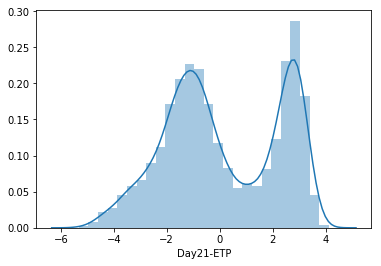

In [8]:
# distribution of continous off-target scores
print('Elevation: Distribution of Off-Target Scores')
sns.distplot(df['Day21-ETP'], kde=True, rug=False)
plt.show()

In [9]:
# new encoding will map to a new alphabet based on the correspondance of guide and off-target
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E', 'N':'W'}
seq_len = len(df['WTSequence'][0])
encoded_seqs = [] 
for idx,(guide,ot) in enumerate(zip(df['WTSequence'], df['MutatedSequence'])):
    new_seq = ''
    for g,o in zip(guide,ot):
        # if '-', imagine it's a match -- may need to CHANGE
        if o == '-': 
            new_seq += new_alph_map[g+g]
            continue
        # combine guide and ot nt to get new letter
        code = g+o
        if code in new_alph_map: new_seq += new_alph_map[code]
        else: new_seq += new_alph_map[o+g] # reverse code
    # NOTE: handle case where some are less than mutated sequence is missing a base at end (just call N/W)
    if len(new_seq) < seq_len:
        encoded_seqs.append(new_seq+'W')
    else: encoded_seqs.append(new_seq)

In [10]:
df['encoded_seqs'] = encoded_seqs
df.head(5)

,ConstructBarcode,MutatedSequence,WTSequence,Annotation,TranscriptID,Protein Annotation,Day21-ETP,Category,Position,encoded_seqs
0,TGTCGTAGTAGGGTATGGGA,TGTCGTAGTAGGGTATGGGA,TGTCGTAGTAGGGTATGGGA,TGG,ENST00000262262,12.64,3.575724,PAM,NaN,LELPELKELKEEELKLEEEK
1,TGGGGAGTTCTTGTCGTAGT,TGGGGAGTTCTTGTCGTAGT,TGGGGAGTTCTTGTCGTAGT,AGG,ENST00000262262,13.74,3.477013,PAM,NaN,LEEEEKELLPLLELPELKEL
2,TCCAGCGAACTTCACCTGAC,TCCAGCGAACTTCACCTGAC,TCCAGCGAACTTCACCTGAC,AGG,ENST00000262262,58.52,3.378409,PAM,NaN,LPPKEPEKKPLLPKPPLEKP
3,CCCCAGGACTACTCACTCCT,CCCCAGGACTACTCACTCCT,CCCCAGGACTACTCACTCCT,CGG,ENST00000262262,53.30,3.353301,PAM,NaN,PPPPKEEKPLKPLPKPLPPL
4,GAACCAGTAACCATGAACTG,GAACCAGTAACCATGAACTG,GAACCAGTAACCATGAACTG,GGG,ENST00000262262,15.38,3.350461,PAM,NaN,EKKPPKELKKPPKLEKKPLE


In [11]:
# get the Y values (what we are trying to predict)
ot_thresh = 1 # based on paper github (see code in file: https://github.com/Microsoft/Elevation/blob/master/elevation/prediction_pipeline.py)
ot_score = [0 if score < ot_thresh else 1 for score in df['Day21-ETP']]
df['off_target_score'] = ot_score

In [12]:
TRAIN_PCT = 0.7

new_alph = list(new_alph_map.values())

# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# dividing data into training and testing 
msk = np.random.rand(len(df)) < TRAIN_PCT
# initial split
train_df = df[msk]
test_df = df[~msk]

# now divide the remaining test data
# one for ensuring we don't overfit; the other, held out until end 
msk = np.random.rand(len(test_df)) < 0.5 # 50% of untrained data is final test data
val_df = test_df[msk]
test_df = test_df[~msk]

# now convert the data into one_hot_encoding 
input_col_name = 'encoded_seqs'
all_data = np.stack(
    [_get_one_hot_encoding(s) for s in df[input_col_name]]).astype(np.float32)
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
val_data = np.stack(
    [_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [13]:
alph_len = len(new_alph)
all_data_f = np.reshape(all_data, (-1,  alph_len* seq_len))
train_data_f = np.reshape(train_data, (-1, alph_len * seq_len))
val_data_f = np.reshape(val_data, (-1, alph_len * seq_len))
test_data_f = np.reshape(test_data, (-1, alph_len * seq_len))

output_col_name = 'Day21-ETP'; 

all_reg = np.array(df[output_col_name].astype(np.float32))
train_reg = np.array(train_df[output_col_name].astype(np.float32))
val_reg = np.array(val_df[output_col_name].astype(np.float32))
test_reg = np.array(test_df[output_col_name].astype(np.float32))

from keras.utils import to_categorical

output_bin_col_name = 'off_target_score'; 

# NOTE: need one-hot encoding of the labels 
all_bins = to_categorical(np.array(df[output_bin_col_name].astype(np.float32)))
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [14]:
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD

In [15]:
Xf = train_data_f
y = train_bins
def simple_model(): 
    # already flattened b/c one_hot encoded
    X_in = Input(shape=(Xf.shape[1],),dtype='float32')
    H = Dense(60, activation = 'relu')(X_in)
    H = Dense(2,activation="sigmoid")(H)
    model = Model(inputs=[X_in], outputs=H)
    #model.summary()
    #crossentropy is for probabilities
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [16]:
num_epochs = 100
model = simple_model()
print(model.summary())
initial_loss, initial_accuracy = model.evaluate(Xf, y)
print("Epoch 0: Loss ", initial_loss, " accuracy ", initial_accuracy)
model.fit(Xf, y, epochs=num_epochs, batch_size=128,validation_data=(val_data_f, val_bins))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 220)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                13260     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 122       
Total params: 13,382
Trainable params: 13,382
Non-trainable params: 0
_________________________________________________________________
None
7098/7098 [==============================] - 0s 15us/step
Epoch 0: Loss  0.6934308350237365  accuracy  0.5280360663968363
Train on 7098 samples, validate on 1476 samples
Epoch 1/100
7098/7098 [==============================] - 0s 26us/step - loss: 0.6102 - acc: 0.6455 - val_loss: 0.5332 - val_acc: 0.7276
Epoch 2/100
7098/7098 [==============================] - 0s 7us/step - loss: 0.4667 - acc: 

7098/7098 [==============================] - 0s 8us/step - loss: 0.1106 - acc: 0.9668 - val_loss: 0.3253 - val_acc: 0.8625
Epoch 55/100
7098/7098 [==============================] - 0s 7us/step - loss: 0.1106 - acc: 0.9649 - val_loss: 0.3371 - val_acc: 0.8618
Epoch 56/100
7098/7098 [==============================] - 0s 8us/step - loss: 0.1059 - acc: 0.9690 - val_loss: 0.3334 - val_acc: 0.8591
Epoch 57/100
7098/7098 [==============================] - 0s 8us/step - loss: 0.1052 - acc: 0.9694 - val_loss: 0.3327 - val_acc: 0.8598
Epoch 58/100
7098/7098 [==============================] - 0s 8us/step - loss: 0.1034 - acc: 0.9707 - val_loss: 0.3327 - val_acc: 0.8652
Epoch 59/100
7098/7098 [==============================] - 0s 7us/step - loss: 0.1013 - acc: 0.9707 - val_loss: 0.3352 - val_acc: 0.8631
Epoch 60/100
7098/7098 [==============================] - 0s 8us/step - loss: 0.0986 - acc: 0.9722 - val_loss: 0.3369 - val_acc: 0.8598
Epoch 61/100
7098/7098 [==============================] - 0s 

Accuracy: 0.8775800711743772 

F1: 0.8691307587664954 



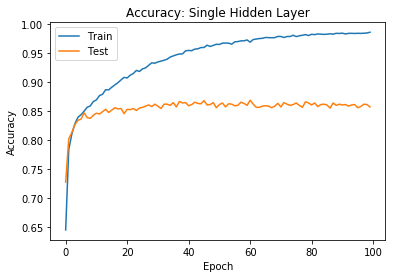

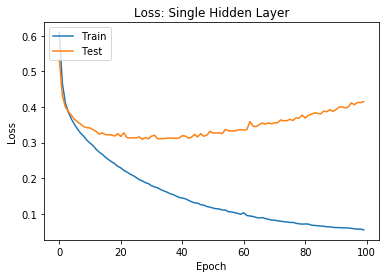

Confusion matrix, without normalization
[[795  86]
 [ 86 438]]


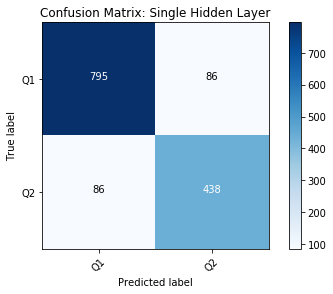

All data confusion matrix
[[0.9  0.1 ]
 [0.16 0.84]]


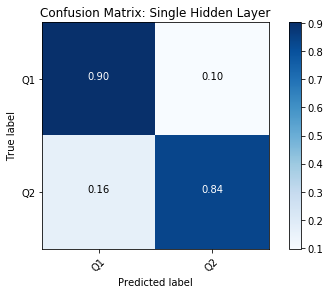

In [17]:
specs = 'Single Hidden Layer'

X_new = test_data_f
y_true = test_bins
y_pred = model.predict(X_new)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1) 

print('Accuracy:', sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels), '\n')
print('F1:', sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

accuracy_plot(model, 'Accuracy: ' + specs)
loss_plot(model, 'Loss: ' + specs)

class_names = ['Q1', 'Q2']
confusion_plot(y_true_labels, y_pred_labels, 'Confusion Matrix: ' + specs, class_names)

In [18]:
y_pred_labels.reshape(-1,1)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [19]:
y_preds

NameError: name 'y_preds' is not defined

In [ ]:
# code from: https://stackoverflow.com/questions/43043271/roc-curve-for-binary-classification-in-python 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
y_preds = [y_pred[i][val] for i,val in enumerate(y_true_labels)]
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels, y_preds)
    roc_auc[i] = auc(fpr[i], tpr[i])

print('auc:',roc_auc_score(y_true_labels, y_preds))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
from sklearn import metrics

# want to compute and plot roc 
# x axis = fpr, y axis = tpr
tn, fp, fn, tp = metrics.confusion_matrix(y_true_labels, y_pred_labels).ravel()
fpr = fp / (tp+fn)
tpr = tp / (tp+fn)

sns.scatterplot(fpr,tpr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
#from sklearn.preprocessing import label_binarize
#from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = y_true_labels
y_score = y_pred_labels
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
data_dir2 = data_dir + 'Haeussler/'
d2 = pd.read_csv(data_dir2+'fig2-crisporData_withReadFraction.tab',sep='\t')

In [ ]:
d2.head(5)

In [ ]:
len(d2)